In [121]:
# Requires extra packages.
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install tokenizers
import pickle
import cloudpickle as cp
import math
import sklearn.metrics # Area Under the ROC calculations.
import matplotlib.pylab as plt # Plotting
from urllib.request import urlopen
import torch
#Downloads a tokenizer that will automatically convert words to indices in a big dictionary.
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')   
# Download tweets.
lst_donald_trump_tweets = cp.load(urlopen("https://raw.githubusercontent.com/gomachinelearning/Blogs/master/DonaldTrumpTweets.pickle"))
lst_joe_biden_tweets = cp.load(urlopen("https://raw.githubusercontent.com/gomachinelearning/Blogs/master/JoeBidenTweets.pickle"))

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


In [122]:
tweet = "% Sorry losers and haters, but my I.Q. is one of the highest"
indexed_tokens = tokenizer.encode(tweet, add_special_tokens=True) 
# Create transition matrix as sparse matrix to save memory.
print(indexed_tokens)
n = tokenizer.vocab_size
print(n)

# Example. 
print('Here are the start and stop tokens: ', tokenizer.encode(''))
print('Here are the start and stop tokens decoded: ', tokenizer.decode(tokenizer.encode('')))
# Example 2.
tweet = "Sorry losers and haters, but my I.Q. is one of the highest"
indexed_tokens = tokenizer.encode(tweet, add_special_tokens=True) 
print('Example encoded tweet: ', indexed_tokens)
print('Example dencoded tweet: ', tokenizer.decode(indexed_tokens, skip_special_tokens=True))

[101, 1003, 3374, 23160, 1998, 5223, 2869, 1010, 2021, 2026, 1045, 1012, 1053, 1012, 2003, 2028, 1997, 1996, 3284, 102]
30522
Here are the start and stop tokens:  [101, 102]
Here are the start and stop tokens decoded:  [CLS] [SEP]
Example encoded tweet:  [101, 3374, 23160, 1998, 5223, 2869, 1010, 2021, 2026, 1045, 1012, 1053, 1012, 2003, 2028, 1997, 1996, 3284, 102]
Example dencoded tweet:  sorry losers and haters, but my i. q. is one of the highest


In [123]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import normalize

class word_ngram():
    def __init__(self):
        self.tokenizer = torch.hub.load('huggingface/pytorch-transformers',
                                        'tokenizer',
                                        'bert-base-uncased')    # Download vocabulary from S3 and cache.
        print('Model initialized with vocab size: ', self.tokenizer.vocab_size) # 30522
        self.stop_token = self.tokenizer.encode(self.tokenizer.sep_token,
                                                add_special_tokens=False)[0]

        return
    
    def fit(self, data):
        '''
        Learn transition probabilities from data.
        Input:
            data = list of tokenized strings to train on.
        '''

        # Create transition matrix as sparse matrix to save memory.
        n = self.tokenizer.vocab_size
        self.transitions = lil_matrix((n,n), dtype=np.float)
        rowTransitionsCount = 0
        for tweet in data[0:-1000]:
          indexed_tokens = tokenizer.encode(tweet, add_special_tokens=True)
          for i in range(len(indexed_tokens)-1):
            self.transitions[indexed_tokens[i], indexed_tokens[i+1]] += 1
            rowTransitionsCount += 1
        
        for i in range(self.transitions.shape[0]):
          self.transitions[i] = self.transitions[i] / np.sum(self.transitions[i])


        # This function will make sure each row sum to one.
        self.transitions = normalize(self.transitions, norm='l1', axis=1)
        return
    
    def evaluate(self, data):
        '''
        Calculate the average log probability of the character transitions.
        Input:
            data = list of tokenized strings to train on.
        Returns:
            mean_logp = (float) average of the log2 probability of the transitions in the data.
        '''
        # if type(data) is str:
        #   data = [data] # Interpret as list of length 1.

        logp_sum = 0
        count = 0

        tweet = tokenizer.encode(data, add_special_tokens=True)
        for i in range(len(tweet)-1):
            p = self.transitions[tweet[i], tweet[i+1]]
            if p == 0:
              self.transitions[tweet[i], tweet[i+1]] = 0.001
            p = self.transitions[tweet[i], tweet[i+1]]
            logp_sum += np.log2(p) 
            count += 1
        mean_logp = logp_sum / count
        return mean_logp

    
    def generate(self, N, prompt=''):
        '''
        Generate a random string of length N starting from prompt.
        This has been written
        '''
        tokens = self.tokenizer.encode(prompt,add_special_tokens=True)
        tokens = tokens[:-1]  # Remove stop token ('[SEP]').
        for i in range(len(tokens), N):
          prev_token = tokens[i-1]
          # Get non-zero probabilities from sparse matrix.
          probs = self.transitions[prev_token, :]
          row = self.transitions[prev_token,:]
          _, indices = row.nonzero()
          if indices is not None and len(indices) > 0:
            probs = row[0, indices].toarray().flatten()
            # Randomly sample from choices with non-zero probs.
            next_token = np.random.choice(indices, p=probs)
          else:
            # Just append a common word. There are obviously better solutions.
            next_token = tokenizer.encode('the', add_special_tokens=False)[0]
          # Append the token to the generated sequence.
          tokens.append(next_token)
          if tokens[-1] == 102:  
            break #
        text = self.tokenizer.decode(tokens, skip_special_tokens=True)
        return text



Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


Model initialized with vocab size:  30522


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


Model initialized with vocab size:  30522

--Start--Trump-vs-Biden--tweet-predictions--


----------------------------------------------------
Generated trump tweet of size  30  and prompt  My thoughts on George Floyd are  :
my thoughts on george floyd are on this was blowing everybody arrive, other very goodnews tonight a reliable supply is the massive navy veteran, let
----------------------------------------------------


----------------------------------------------------
Generated Biden tweet of size  30  and prompt  Climate crisis  :
climate crisis and we can have had to go back. https : / / / t. it ’ t. i applaudq + equality
----------------------------------------------------


----------------------------------------------------
Generated trump tweet of size  30  and prompt  Climate crisis  :
climate crisis, and uphold the plague.. nobody better than 5m
----------------------------------------------------


----------------------------------------------------
Generated Biden 

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])



------ROC----------
Accuracy =  0.936
fpr and tpr =  [0.    0.018 1.   ]  -  [0.   0.89 1.  ]


Text(0, 0.5, 'True Positive Rate')

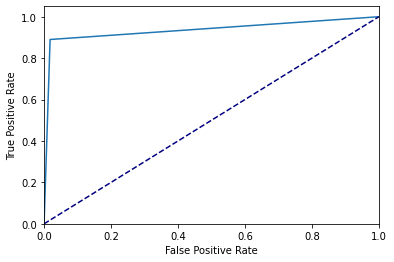

In [124]:
gramTrump = word_ngram()
gramTrump.fit(lst_donald_trump_tweets)
gramBiden = word_ngram()
gramBiden.fit(lst_joe_biden_tweets)

print("\n--Start--Trump-vs-Biden--tweet-predictions--")

def trumpTweets(prompt):
  #---------------------TRUMP---------------------------------------
  print("\n")
  tweetSize = 30
  tweetPrompt = prompt
  tweet = gramTrump.generate(tweetSize, tweetPrompt)
  print("----------------------------------------------------")
  print("Generated trump tweet of size ", tweetSize, " and prompt ", tweetPrompt, ":")
  print(tweet)
  print("----------------------------------------------------")

def bidenTweets(prompt):
  #-------------BIDEN--------------------------------------------
  print("\n")
  tweetSize = 30
  tweetPrompt = prompt
  tweet = gramBiden.generate(tweetSize, tweetPrompt)
  print("----------------------------------------------------")
  print("Generated Biden tweet of size ", tweetSize, " and prompt ", tweetPrompt, ":")
  print(tweet)
  print("----------------------------------------------------")

trumpTweets("My thoughts on George Floyd are ")
bidenTweets("Climate crisis ")
trumpTweets("Climate crisis ")
bidenTweets("My thoughts on George Floyd are ")

#-----------------EVALUATE TRUMP---------------------
print()
print("----------------------------------------------------")
print("\nEvaluate last string in Trump data using Mean Log Likelihood" )
print("Last string:\n", lst_donald_trump_tweets[-1])

trumpLikelihood = gramTrump.evaluate(lst_donald_trump_tweets[-1])
print("Mean_logp = ", trumpLikelihood)
print("----------------------------------------------------\n")

#-----------------EVALUATE BIDEN---------------------
print()
print("----------------------------------------------------")
print("Evaluate last string in Trump data using Mean Log Likelihood" )
print("Last string:\n", lst_donald_trump_tweets[-1])
bidenLikelihood = gramBiden.evaluate(lst_donald_trump_tweets[-1])
print("Mean_logp = ", bidenLikelihood)
print("----------------------------------------------------")

#-----------------BAYES RULE---------------------
print("----------------------------------------------------")
print("Using bayes rules to pick who wrote the last tweet in trumps data")
likelihoodTrumpGivenTweet = 1 / (1 + math.exp(bidenLikelihood - trumpLikelihood))
print("likelihoodTrump = ", likelihoodTrumpGivenTweet)
likelihoodBidenGivenTweet = 1 / (1 + math.exp(trumpLikelihood - bidenLikelihood))
print("likelihoodBiden = ", likelihoodBidenGivenTweet)

#-----------------TEST SET ROC---------------------
testTrump = lst_donald_trump_tweets[-1000:]
testBiden = lst_joe_biden_tweets[-1000:]

countFP = 0 #False Positive Count
countTP = 0 #True Positive Count
countFN = 0 #False Negative Count
countTN = 0 #True Negative count

#---Matrix for roc curve sklearn-----
rocMatrix = np.zeros(shape=(2000, 2))
rocMatrix[:1000,0] = 1
rocMatrix[1000:,0] = 0

trumpTestCount = 0
for tweet in testTrump:
  trumpLikelihood = gramTrump.evaluate(tweet)
  bidenLikelihood = gramBiden.evaluate(tweet)
  likelihoodTrumpGivenTweet = 1 / (1 + math.exp(bidenLikelihood - trumpLikelihood))
  likelihoodBidenGivenTweet = 1 / (1 + math.exp(trumpLikelihood - bidenLikelihood))

  if likelihoodTrumpGivenTweet <= .5:
    countFN += 1
  if likelihoodTrumpGivenTweet > .5:
    rocMatrix[trumpTestCount, 1] = 1
    countTP += 1
  if likelihoodBidenGivenTweet <= .5:
    countTN += 1
  if likelihoodBidenGivenTweet > .5:
    countFP += 1

  trumpTestCount += 1

bidenTestCount = 1000
for tweet in testBiden:
  bidenLikelihood = gramBiden.evaluate(tweet)
  trumpLikelihood = gramTrump.evaluate(tweet)
  likelihoodBidenGivenTweet = 1 / (1 + math.exp(trumpLikelihood - bidenLikelihood))
  likelihoodTrumpGivenTweet = 1 / (1 + math.exp(bidenLikelihood - trumpLikelihood))

  if likelihoodTrumpGivenTweet > .5:
    rocMatrix[bidenTestCount,1] = 1
    countFP += 1
  if likelihoodTrumpGivenTweet <= .5:
    countTN += 1
  if likelihoodBidenGivenTweet > .5:
    countTP += 1
  if likelihoodBidenGivenTweet <= .5:
    countFN += 1 

  bidenTestCount += 1


auroc = (countTP + countTN) / (countTP + countFP + countTN + countFN)

print("\n------ROC----------")
print("Accuracy = ", auroc)

# fpr = countFP / (countFP + countTN)
# tpr = countTP / (countTP + countFN)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(rocMatrix[:,0], rocMatrix[:,1])
print("fpr and tpr = ", fpr, " - ", tpr)
# Plot ROC curve.
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')